In [1]:
import functools

import jax
import jax.numpy as jnp
from jax_spe import spe
import numpy as np
import matplotlib.pyplot as plt
from flax import nn

In [2]:
jax.config.update('jax_platform_name', 'cpu')

In [3]:
# dimension for the keys and queries
keys_dim = 64
num_heads = 8
num_realizations = 64
num_sines = 10
kernel_size = 20

conv = True

In [4]:
class Encoder(nn.Module):

    def apply(self, rng_key, q, k, conv=False):
        if conv:
            qbar, kbar = spe.ConvSPE(
                rng_key, q.shape,
                kernel_size=kernel_size,
                num_realizations=num_realizations)
        else:
            qbar, kbar = spe.SineSPE(
                rng_key, q.shape,
                num_sines=num_sines,
                num_realizations=num_realizations)
        qbar, kbar = spe.SPEGate(rng_key, (qbar, kbar))
        return spe.apply_spe(q, qbar), spe.apply_spe(k, kbar)

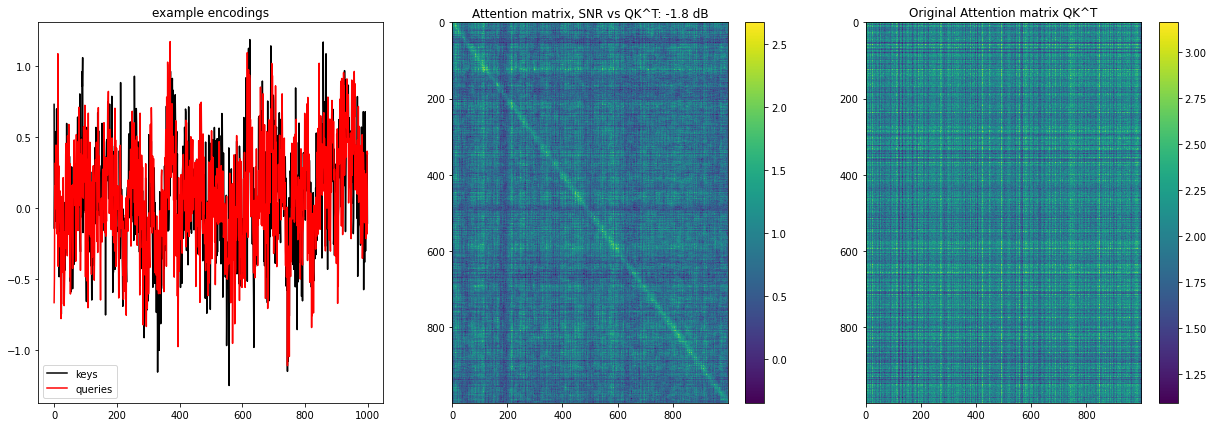

In [7]:
n = 1000
batchsize = 8

# generate some keys and queries of shape (batchsize, num, n)
q = jax.random.uniform(jax.random.PRNGKey(0), (batchsize, n, num_heads, keys_dim))
k = jax.random.uniform(jax.random.PRNGKey(1), (batchsize, n, num_heads, keys_dim))

_, params = Encoder.init(jax.random.PRNGKey(0), jax.random.PRNGKey(0), q, k, conv=conv)

# Test if jitting works correctly
@jax.jit
def encode(q, k, conv=conv):
    return Encoder.call(params, jax.random.PRNGKey(1), q, k, conv=conv)

A0 = q[0,:,0,:] @ k[0,:,0,:].T / jnp.sqrt(keys_dim)
q, k = encode(q, k)
A = q[0,:,0,:] @ k[0,:,0,:].T / jnp.sqrt(num_realizations)

plt.figure(figsize=[21,7]);
plt.subplot(131)
plt.plot(k[0,:,0,0],'k');
plt.plot(q[0,:,0,0],'r');
plt.title('example encodings');
plt.legend(['keys', 'queries']);

# display the average dot product
plt.subplot(132);
plt.imshow(A, aspect='auto', interpolation='nearest');
plt.title('Attention matrix, SNR vs QK^T: %0.1f dB'%(10*jnp.log10(jnp.linalg.norm(A)/jnp.linalg.norm(A-A0))));
plt.colorbar();

plt.subplot(133);
plt.imshow(A0, aspect='auto', interpolation='nearest');
plt.title('Original Attention matrix QK^T');
plt.colorbar();